
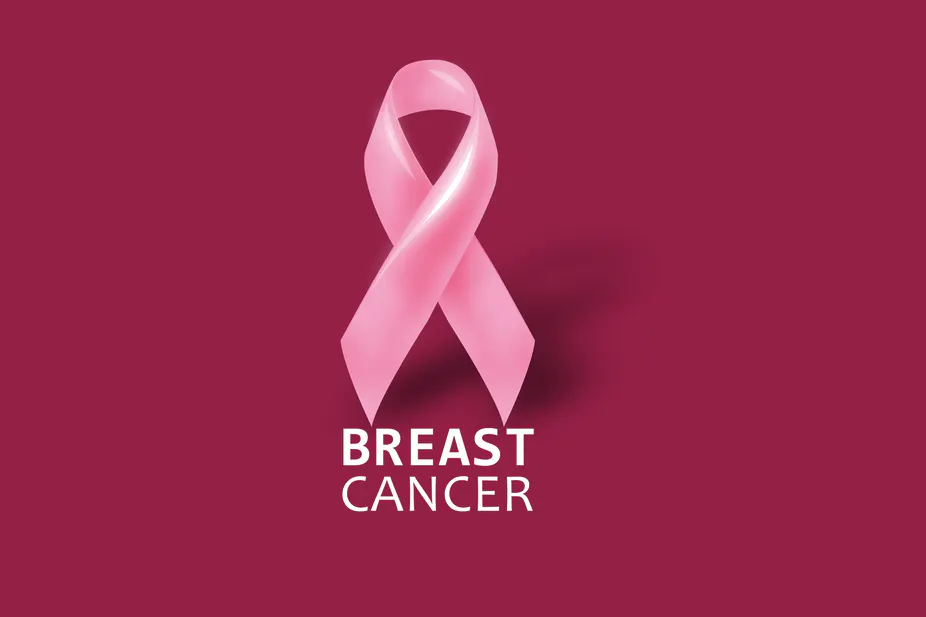

**About the Dataset:**
<h1 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> About this Kernel </h1>


* The Breast Cancer datasets is available UCI machine learning repository maintained by the University of California, Irvine. 
* The dataset contains 569 samples of malignant and benign tumor cells.

* The first two columns in the dataset store the unique ID numbers of the samples and the corresponding diagnosis (M=malignant, B=benign), respectively. 
* The columns 3-32 contain 30 real-value features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.

    * 1= Malignant (Cancerous) - Present (M)
    * 0= Benign (Not Cancerous) -Absent (B)
    
    
    
**Ten real-valued features are computed for each cell nucleus:**


* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

    * All feature values are recoded with four significant digits.

    * Missing attribute values: none

> Class distribution: 357 benign, 212 malignant

In [ ]:
import numpy as np #linear algebra
import pandas as pd #data processing

import matplotlib.pyplot as plt #data visualization
import seaborn as sns #data visualization

import warnings
warnings.filterwarnings("ignore") #to ignore the warnings

#for model building
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [ ]:
# Loading the data
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')

In [ ]:
df.head()

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>

* The last column named "Unaname: 32" seems like an erronous coloumn in our dataset. We might probably just drop it.
* Most of the columns seem to have a numeric entry. This would save our time from mapping the variables.
* The ID column would not help us contributing to predict about the cancer. We might as well drop it.

In [ ]:
df.info()

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>

* Only the 'diagnosis' column, which we have to predict is of object datatype.
* There's only ID column of int type. We will probably drop it anyway.
* There are a total of 31 columns which are of float datatype.

In [ ]:
df.drop(['Unnamed: 32','id'], axis = 1 , inplace=True)
df.columns

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>
After dropping the two columns, we are now left with 31 columns. Let us see how well do they correlate with the diagnosis column. 

In [ ]:
df.diagnosis.replace({"M":1,"B":0},inplace=True)
df.diagnosis.unique()

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>
In order to conduct our analysis easily, we have converted the target column as:

* Malignant - 1
* Benignant - 0

In [ ]:
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='YlGnBu', annot = True)
plt.title("Correlation Map", fontweight = "bold", fontsize=16)

In [ ]:
corr[abs(corr['diagnosis']) > 0.59].index

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>
The following columns are the one's that show the greatest correlation with our diagnosis column. There are two things that can be done. 
* We can either use only the columns which have greatest correlation, or we can continue to use all the columns.
* I will be using all these columns to predict our result
* You can eliminate a few and see if the accuracy improves!

In [ ]:
df.drop('diagnosis', axis=1).corrwith(df.diagnosis).plot(kind='bar', grid=True, figsize=(12, 10), title="Correlation with target",color="green");

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>
Looks wonderful, isn't it! 
* There are only a handful of columns that show negative correlation with the 'diagnosis column'
* Around half of our columns are more than 50% positively correlated to diagnosis column.

We have to select which of the attributes we want to use in building our model!


In [ ]:
corr_matrix = df.corr()
threshold = 0.60 
filtre = np.abs(corr_matrix["diagnosis"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(df[corr_features].corr(), annot = True, cmap="YlGnBu")
plt.title("Correlation Between Features w Corr Theshold 0.60", fontweight = "bold", fontsize=16)
plt.show()

In [ ]:
#pair plot
sns.pairplot(df[corr_features], diag_kind = "kde", markers = "+", hue = "diagnosis", palette='viridis')
plt.show()

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>
We would need to eliminate the outliers so that it does not affects our model's accuracy. Let us see if there are any outliers present in the dataset!

**About The Local Outlier Factor**

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# split the data to X and y before Local Outlier Factorization

y=df["diagnosis"]
X=df.drop(["diagnosis"],axis=1)
columns= df.columns.tolist()

In [ ]:
lof= LocalOutlierFactor()
y_pred=lof.fit_predict(X)
y_pred[0:30]
#  1 = inlier
# -1 = outlier

**<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>
:** 
So there are 3 columns that have outliers, lets plot them and check them out!

In [ ]:
x_score= lof.negative_outlier_factor_
outlier_score= pd.DataFrame()
outlier_score["score"]=x_score

lofthreshold= -2.5
loffilter= outlier_score["score"]< lofthreshold
outlier_index= outlier_score[loffilter].index.tolist()

In [ ]:
plt.figure(figsize=(12,8.))
plt.scatter(X.iloc[outlier_index,0],X.iloc[outlier_index,4],color="blue",s=50,label="outliers")
plt.scatter(X.iloc[:,0],X.iloc[:,4],color="k",s=3,label="Data Points")

radius=(x_score.max()- x_score)/(x_score.max()-x_score.min())
outlier_score["radius"]=radius
plt.scatter(X.iloc[:,0],X.iloc[:,4],s=1000*radius,edgecolors="r",facecolors="none",label="outlier scores")
plt.legend();

In [ ]:
X= X.drop(outlier_index)
y= y.drop(outlier_index).values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NeighborhoodComponentsAnalysis
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

# Dont fit the scaler while standardizate X_test !
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
key = ['LogisticRegression','KNeighborsClassifier','SVC','DecisionTreeClassifier','RandomForestClassifier','GradientBoostingClassifier','AdaBoostClassifier','XGBClassifier']
value = [LogisticRegression(), KNeighborsClassifier(n_neighbors = 2, weights ='uniform'), SVC(kernel="rbf",random_state=15), DecisionTreeClassifier(random_state=10), RandomForestClassifier(n_estimators=60, random_state=0), GradientBoostingClassifier(random_state=20), AdaBoostClassifier(), xgb.XGBClassifier(random_state=0,booster="gbtree")]
models = dict(zip(key,value))
models

In [ ]:
predicted =[]
for name,algo in models.items():
    model=algo
    model.fit(X_train,y_train)
    predict = model.predict(X_test)
    acc = accuracy_score(y_test, predict)
    predicted.append(acc)
    print(name,acc)

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(x = predicted, y = key, palette='pastel')
plt.title("Plotting the Model Accuracies", fontsize=16, fontweight="bold")

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>
We can clearly see that all our models perform with more than 90% accuracy where DecisionTreeClassifier has the lowest of 90.058% and LogisticRegression has the highest of 98.25% accuracy.

Let us see if we can further improve the accuracy of our model by adding a few changes to it!


In [ ]:
lr = LogisticRegression(solver='lbfgs', max_iter=10000)
rs = []
acc = []
for i in range(1,25,1):
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = i)    
    model_lr_rs = lr.fit(X_train, y_train)
    predict_values_lr_rs = model_lr_rs.predict(X_test)
    acc.append(accuracy_score(y_test, predict_values_lr_rs))
    rs.append(i)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(rs, acc, color ='red')

for i in range(len(rs)):
    print(rs[i],acc[i])


From the above figure we can see that our model touches somewhere around 99% between (20-25). Let's try to see where exactly does this happen!

In [ ]:
for i in range(0,24):
    if acc[i] > 0.98:
        print(acc[i])

<h3 style = "font-family: Comic Sans MS;background-color:#ff99cc	"> Observations: </h3>
From the above plot we may conclude that highest accuracy is achieved at 20th iteration.

Wohhoo, We have finally built a model with an accuracy of 99.12%!

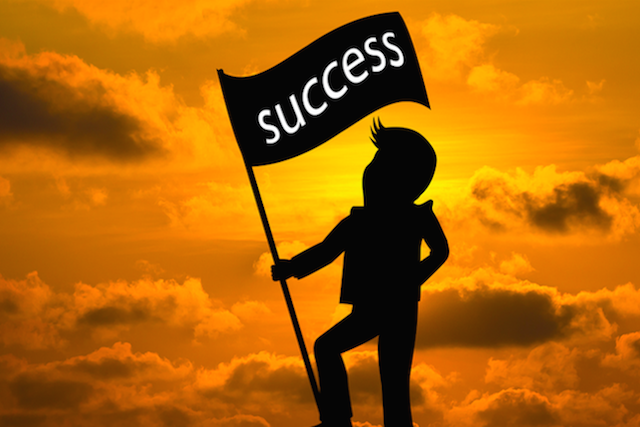

**Summary:** We used a total of 8 models in order to achieve our final result. 


    * LogisticRegression 99.12 %
    
    * KNeighborsClassifier 95.32 %
    
    * SVC 96.50 %
    
    * DecisionTreeClassifier 90.05 %
    
    * RandomForestClassifier 96.50 %
    
    * GradientBoostingClassifier 97.67 %
    
    * AdaBoostClassifier 96 %
    
    * XGBClassifier 97.67 %


> *Thanks a lot for checking this out till the end!*